In [1]:
###########################################################################
#Developed by Jonathan Ojeda 29/1/2021 QAAFI UQ
# Code functionalities:
# Read netCDF using xarray
# Explore and plot multidimensional files using xarray 
# Create maps using xarray and dataframes
# Create 2D dataframe from xarray
# Create Multi-dimensional xarray from 2D pandas dataframe
###########################################################################

In [1]:
#Required packages
import os
os.environ["PROJ_LIB"] = r'C:\Users\uqjojeda\Anaconda3\Library\share'; #fixr
from netCDF4 import Dataset
import numpy as np
from matplotlib import pyplot as plt
import xarray as xr
import pandas as pd
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import cartopy.io.shapereader as shpreader
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import seaborn as sns
import matplotlib.ticker as ticker
import glob
import geopandas as gpd

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
#Tool to minimize code and see only figures

from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [371]:
#Read different outputs:
#run005 --> harvesting at 200 DAS
#run004 --> harvesting at 300 degre days after flowering
#r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\output.nc4' --> harvesting at 150 DAS
#run007 --> harvesting at 120 DAS
#run008 --> harvesting at 120 DAS withouth crop mask
#run012 --> harvesting at 120 DAS withouth crop mask, add some variables of stress and remaining tiles in Texas
#run013 --> harvesting at 120 DAS withouth crop mask, add partitioned variables for climate
#run014 --> same 013 and change in irrigation routine
#run016 --> change in planting dates to corn PD 
#run017 --> change in planting dates to corn PD and adding ET values as variables

#Read and merge all nc files from psims (if more than a file in a folder write *.nc4 at the end of the address)
df_final = xr.merge([xr.open_dataset(f, decode_times=False) for f in glob.glob(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\new\run018\output.nc4')])

In [5]:
#df_final.to_netcdf(r'C:/Users/uqjojeda/Nextcloud/PURTERRA-A0131/2020/outputs/new/run00/all_final.nc')

<AxesSubplot:ylabel='Frequency'>

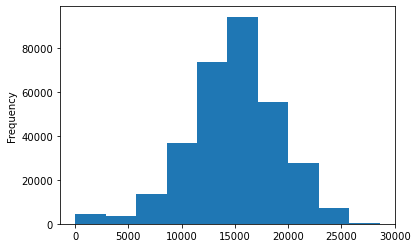

In [182]:
df.biomass.plot.hist()

In [125]:
df_final.biomass[0:,0:,0:,0:,0:].values.shape

(30, 4, 2, 72, 52)

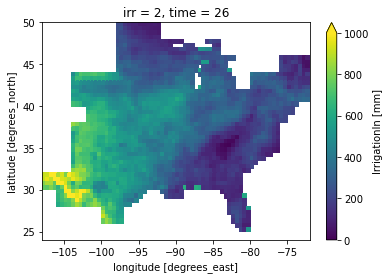

In [126]:
#use campaign nc file in run010
#use campaign file in created C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\data\campaign\created_campaign\test6 folder (this is the right one)
#for the following factor configuration:

#scen_new:0,irr:0 GS dry
#scen_new:1,irr:0 SS dry
#scen_new:2,irr:0 FSPS dry
#scen_new:3,irr:0 FS dry
#scen_new:0,irr:1 GS irrigated
#scen_new:1,irr:1 SS irrigated
#scen_new:2,irr:1 FSPS irrigated
#scen_new:3,irr:1 FS irrigated

df_final.IrrigationIn[25,3,1,0:,0:].plot(yincrease=True, x='lon', y='lat', vmin=0, vmax=1000)

## Work with multidimensional dataframes using xarray

In [372]:
#Create biomass variable in t ha-1
df_final['biomass2'] = df_final['biomass']/1000
# Remove values considered as crop failures < quantile(0.025)
#data4 = df_final.where(df_final['biomass'] > 5922.5) #df.biomass.quantile(0.025)

#Remove lat and lon combinations that were outside the study area. For this we need to convert the xarray to a 2D dataframe
#Conver multidimendional frame to 2D frame
data = df_final.to_dataframe()
data.reset_index(drop=False, inplace=True)
df = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\SorghumMask\OutsideAreas.csv')
coordinate_list = [list(row) for row in df.values]
dropSet = {tuple(elem) for elem in coordinate_list}

# Creates a multi-index on letter/colour.
temp = data.set_index(['lat', 'lon'])

# Keep all elements of the index except those in droplist.
temp = temp.loc[list(set(temp.index) - dropSet)]

# Reset index to get the original column layout.
df_dropped = temp.reset_index()

#Rename
df_dropped.rename(columns={'scen_new':'cultivar'}, inplace=True)
#df_dropped.set_index(['lat', 'lon', 'cultivar', 'irr','time'], inplace=True)

#Remove cells with 0% of cropland accordingly with AgMERRA dataset
landuse = pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\landuse.csv')
data3 = pd.merge(landuse, df_dropped, how ='inner', on =['lat','lon']) 

#data2 = data3.drop(['rain_a_x','radn_a_x','rain_b_x','radn_b_x','rain_c_x','radn_c_x','wind_a_x','hur_a_x','hurtmax_a_x','cropland_a_x',
# 'tmax_a_x', 'tmin_a_x', 'tmean_a_x', 'wind_b_x', 'hur_b_x', 'hurtmax_b_x', 'cropland_b_x', 'tmax_b_x', 'tmin_b_x',
# 'tmean_b_x','wind_c_x', 'hur_c_x', 'hurtmax_c_x', 'cropland_c_x', 'tmax_c_x', 'tmin_c_x', 'tmean_c_x', 'radn_x',
# 'rain_x', 'tmin_x', 'tmax_x', 'tmean_x', 'wind_x', 'hur_x', 'hurtmax_x', 'env_x', 'rain_a_y', 'radn_a_y',
# 'rain_b_y', 'radn_b_y', 'rain_c_y', 'radn_c_y', 'wind_a_y', 'hur_a_y', 'hurtmax_a_y', 'cropland_a_y', 'tmax_a_y',
# 'tmin_a_y', 'tmean_a_y', 'wind_b_y', 'hur_b_y','hurtmax_b_y', 'cropland_b_y', 'tmax_b_y', 'tmin_b_y', 'tmean_b_y',
# 'wind_c_y', 'hur_c_y', 'hurtmax_c_y', 'cropland_c_y', 'tmax_c_y', 'tmin_c_y', 'tmean_c_y', 'radn_y', 'rain_y',
# 'tmin_y', 'tmax_y', 'tmean_y', 'wind_y', 'hur_y', 'hurtmax_y', 'cropland_y', 'env_y'], axis=1)

#Set index before to create the xarray
data1 = data3.set_index(['lat','lon','cultivar','irr','time'])

#From 2D dataframe to xarray
data4 = data1.to_xarray()
#remove data from West Virginia state which was out of bioenergy crop mask
#d1 = dataPre3.where(dataPre3.biomass != dataPre3.biomass[0:,0:,0:,52,24], drop=True)

In [373]:
#Conver multidimendional frame to 2D frame
data4pd = data4.to_dataframe()
dfc = data4pd[data4pd.biomass != 0]
dfc.reset_index(level=[0,1,2,3], inplace=True)
dfc.rename(columns={'scen_new':'cultivar'}, inplace=True)
df = dfc.dropna()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [374]:
failures = df[df['biomass'] < 5922.5]

mean_failures0 = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
mean_failures = mean_failures0[['lat','lon','cultivar','irr','biomass2']]
count_failures0 = failures.groupby(['lat', 'lon','cultivar','irr'],as_index=False).count()
count_failures = count_failures0[['lat','lon','cultivar','irr','biomass2']]
count_failures.rename(columns={'biomass2':'NoFailures'}, inplace=True)
count_failures['years'] = 30
count_failures['FailureRisk'] = count_failures['NoFailures']/count_failures['years']*100
all_failures = pd.merge(mean_failures, count_failures, how ='inner', on =['lat','lon','irr','cultivar'])

all_failures.loc[all_failures.cultivar == 0, 'cv'] = "GS"
all_failures.loc[all_failures.cultivar == 1, 'cv'] = "SS"
all_failures.loc[all_failures.cultivar == 2, 'cv'] = "PS"
all_failures.loc[all_failures.cultivar == 3, 'cv'] = "PI"

all_failures.loc[all_failures.irr == 1, 'irri'] = "R"
all_failures.loc[all_failures.irr == 2, 'irri'] = "I"

all_failures_spatial00 = all_failures.reset_index()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\pandas\core\frame.py:4438: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(
<ipython-input-374-894e4faa7082>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_failures['years'] = 30
<ipython-input-374-894e4faa7082>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus

In [290]:
all_failures_spatial00 = all_failures.reset_index()
all_failures_spatial0 = all_failures_spatial00.set_index(['lat','lon','cultivar','irr'])
all_failures_spatial = all_failures_spatial0.to_xarray()

In [294]:
#all_failures_spatial.to_netcdf(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\Maps\Failures\failures.nc4')

<ipython-input-292-098b4a59c584>:72: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


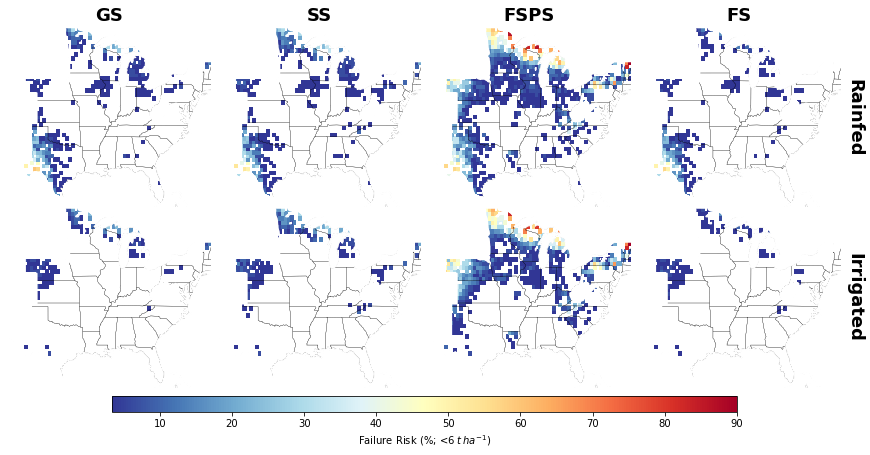

In [292]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = all_failures_spatial.FailureRisk.plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj},
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Failure Risk (%; <6 $t\,ha^{-1}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\NoFailures.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [ ]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = all_failures_spatial.FailureRisk.plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj},
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Failure Risk (%; <6 $t\,ha^{-1}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\NoFailures.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

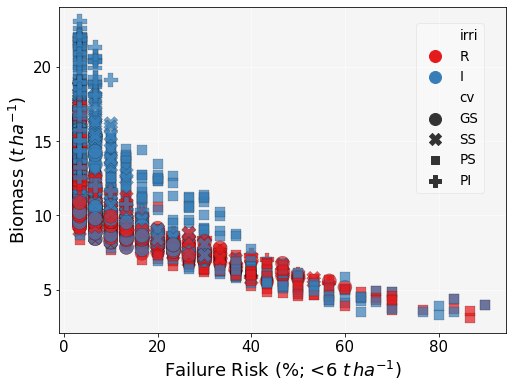

In [293]:
kwargs  =   {'edgecolor':"k"}
fig = plt.figure(figsize=(8,6))

ax=plt.subplot(1, 1, 1)

sns.scatterplot(x="FailureRisk", y="biomass2",hue='irri', style='cv', alpha=0.7, data=all_failures, linewidth=0.2,**kwargs,s=200, palette='Set1')

# Formatting graph and background
plt.legend(prop=dict(size=13.5),bbox_to_anchor=(0.8, 0.95), loc=2, borderaxespad=0., ncol=1,framealpha=0.3,markerscale=2)
plt.ylabel('Biomass ($t\,ha^{-1}$)', fontsize =18)
plt.xlabel('Failure Risk (%; <6 $t\,ha^{-1}$)', fontsize =18)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=15)
ax.xaxis.set_tick_params(labelsize=15)
#ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
#ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
#ax.set_xlim([100.1,159.9])
#ax.set_ylim([100.1,159.9])
plt.tick_params(axis='x', which='both', bottom=True, top=False, labelbottom=True)
plt.tick_params(axis='y',which='both',left=True)
#ax.get_legend().remove()

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\NoFailuresXY.png', dpi=600, bbox_inches='tight', pad_inches=0)

In [15]:
#df["irrigation"] = ["rainfed" if ele < 2 else "irrigated" for ele in df["cultivar"]]

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-174-651bd4a5c040>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


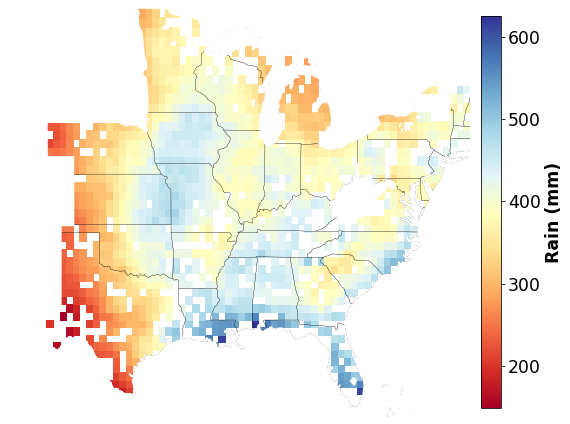

In [174]:
#Plotting single map with mean accum rain
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.RainIn.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu, add_colorbar=False, zorder=1, vmin=a.RainIn.quantile(0), vmax=a.RainIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Rain (mm)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rain.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-46-8c0d439ba159>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


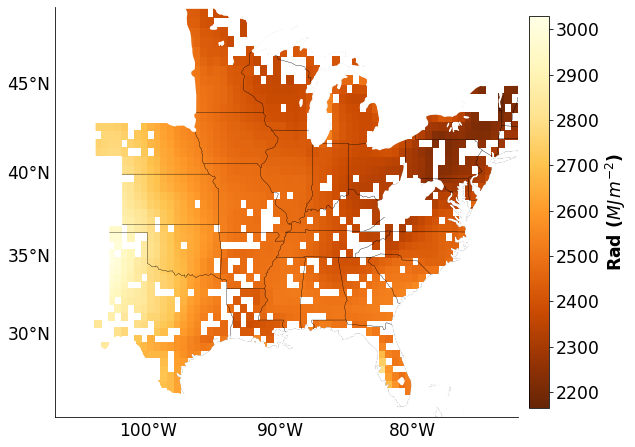

In [46]:
#Plotting single map with mean accum radiation
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.RadiationIn.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.YlOrBr_r, add_colorbar=False, zorder=1, vmin=a.RadiationIn.quantile(0), vmax=a.RadiationIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=True,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 17, 'color': 'k'}
gl.ylabel_style = {'size': 17, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='Rad ($MJ\,m^{-2}$)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)
ax.spines['left'].set_visible(True)  
ax.spines['bottom'].set_visible(True)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rad.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-47-1c6b1c938b78>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


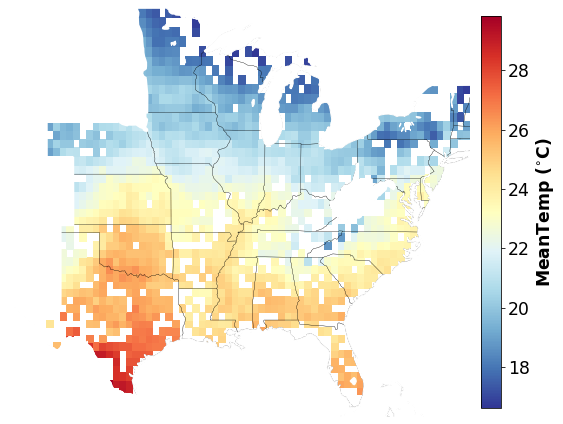

In [47]:
#Plotting single map with mean temperature during the growing cycle
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.TempIn.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.RdYlBu_r, zorder=1, add_colorbar=False, vmin=a.TempIn.quantile(0), vmax=a.TempIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='MeanTemp ($^{\circ}$C)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\temp.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-535-d4913f7d03fb>:60: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


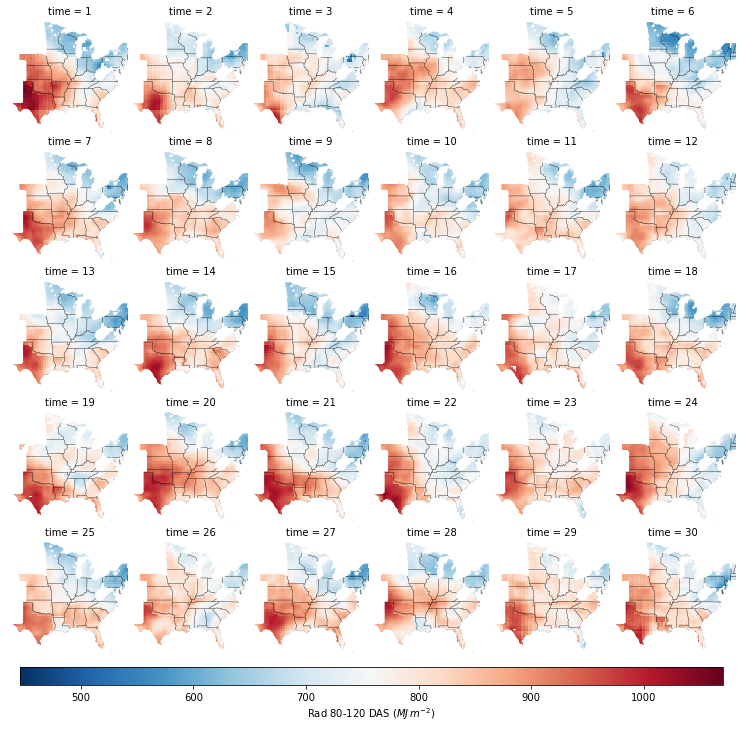

In [535]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.radHarv.mean(dim=('irr','cultivar'), skipna=True).plot(x='lon', y='lat',col='time', col_wrap=6,
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj},
    figsize=(18,14),
    cmap=mpl.cm.RdBu_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.7, hspace=0.17)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Rad 80-120 DAS ($MJ\,m^{-2}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rad80-120.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-320-edbfc6181c3e>:93: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


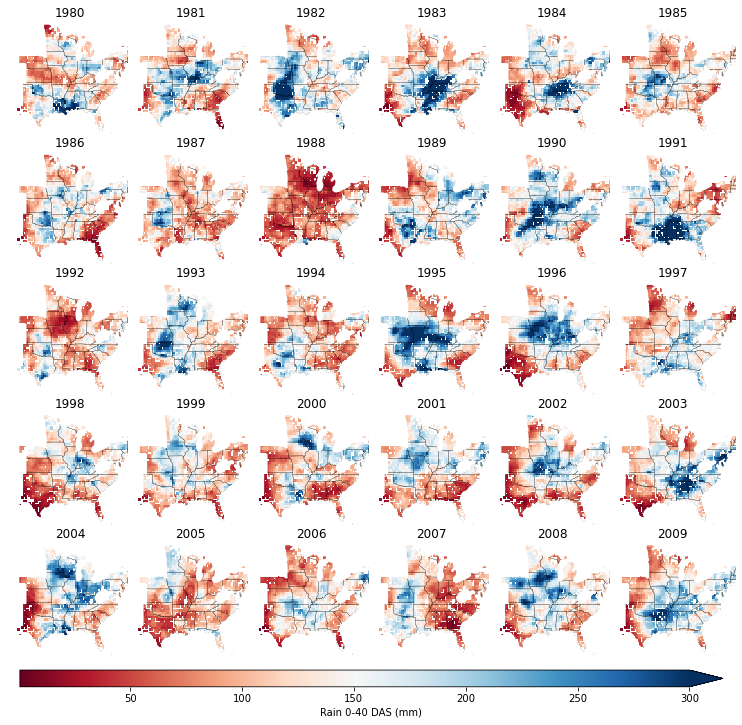

In [320]:
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.rain40DAS.mean(dim=('cultivar','irr'), skipna=True).plot(x='lon', y='lat', col='time', col_wrap=6,
    transform=ccrs.PlateCarree(central_longitude=0), vmax=300,
    subplot_kws={'projection': map_proj},
    figsize=(18,14),
    cmap=mpl.cm.RdBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("1980", fontsize=12)
axes[1].set_title("1981", fontsize=12)
axes[2].set_title("1982", fontsize=12)    
axes[3].set_title("1983", fontsize=12)
axes[4].set_title("1984", fontsize=12)
axes[5].set_title("1985", fontsize=12)
axes[6].set_title("1986", fontsize=12)
axes[7].set_title("1987", fontsize=12)
axes[8].set_title("1988", fontsize=12)
axes[9].set_title("1989", fontsize=12)
axes[10].set_title("1990", fontsize=12)
axes[11].set_title("1991", fontsize=12)
axes[12].set_title("1992", fontsize=12)
axes[13].set_title("1993", fontsize=12)
axes[14].set_title("1994", fontsize=12)
axes[15].set_title("1995", fontsize=12)
axes[16].set_title("1996", fontsize=12)
axes[17].set_title("1997", fontsize=12)
axes[18].set_title("1998", fontsize=12)
axes[19].set_title("1999", fontsize=12)
axes[20].set_title("2000", fontsize=12)
axes[21].set_title("2001", fontsize=12)
axes[22].set_title("2002", fontsize=12)
axes[23].set_title("2003", fontsize=12)
axes[24].set_title("2004", fontsize=12)
axes[25].set_title("2005", fontsize=12)
axes[26].set_title("2006", fontsize=12)
axes[27].set_title("2007", fontsize=12)
axes[28].set_title("2008", fontsize=12)
axes[29].set_title("2009", fontsize=12)

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.7, hspace=0.17)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Rain 0-40 DAS (mm)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\rad80-120.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
<ipython-input-48-58e69d643fac>:77: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


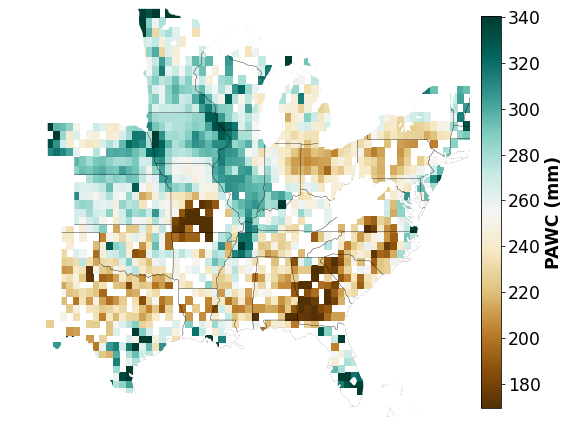

In [48]:
#Plotting single map with mean temperature during the growing cycle
a = df.groupby(['lat', 'lon'],as_index=False).mean()
fig, ax = plt.subplots(1, 1, subplot_kw=dict(projection=ccrs.Mercator(central_longitude=-95)),figsize=(10,8))

p=data4.PAWC.mean(dim=('time','cultivar','irr'), skipna=True).plot(x='lon', y='lat', transform=ccrs.PlateCarree(central_longitude=0),
robust=True, cmap=mpl.cm.BrBG, zorder=1, add_colorbar=False) #vmin=a.TempIn.quantile(0), vmax=a.TempIn.quantile(1))

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                draw_labels=False,dms=True, x_inline=False, y_inline=False)
#ax.coastlines(color='k',linewidth=0.3, zorder=4)
ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlocator = mticker.FixedLocator([-100, -90, -80])
gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10, 'color': 'k'}
gl.ylabel_style = {'size': 10, 'color': 'k'}

for value in iso4 :
    area2(ax, value, "white", 4)

area2(ax, value, "white", 4)

for value in iso3 :
    area(ax, value, "white")

area(ax, value, "white")

#Colorbar attributes
cb = plt.colorbar(p, orientation="vertical", pad=0.02, shrink=0.9)
cb.set_label(label='PAWC (mm)', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')

ax.outline_patch.set_visible(False)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\pawc.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-171-8d79f8f55502>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


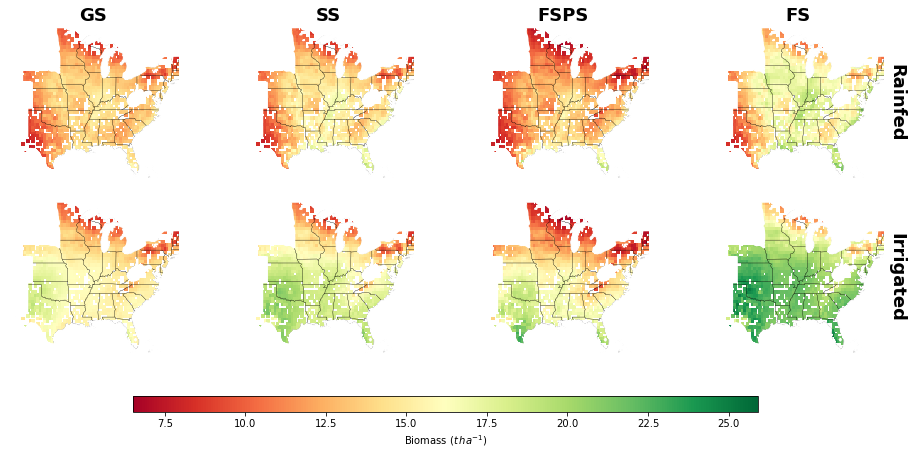

In [171]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.biomass2.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #=a.biomass2.min(),vmax=a.biomass2.max(),
    figsize=(16,8),
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#    gl.top_labels = False
#    gl.left_labels = True
#    gl.right_labels =False
#    gl.xlines = False
#    gl.ylines = False
#    gl.xlocator = mticker.FixedLocator([]) #-120, -100, -80
#    gl.ylocator = mticker.FixedLocator([]) #25, 35, 45
#    gl.xformatter = LONGITUDE_FORMATTER
#    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlabel_style = {'size': 10, 'color': 'k'}
#    gl.ylabel_style = {'size': 10, 'color': 'k'}

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.25, hspace=0.15)
p.add_colorbar(orientation='horizontal', pad=0.1, shrink=0.7, aspect=40, label='Biomass ($t\,ha^{-1}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\mean_biomass0.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-157-1c351eb2e7b9>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


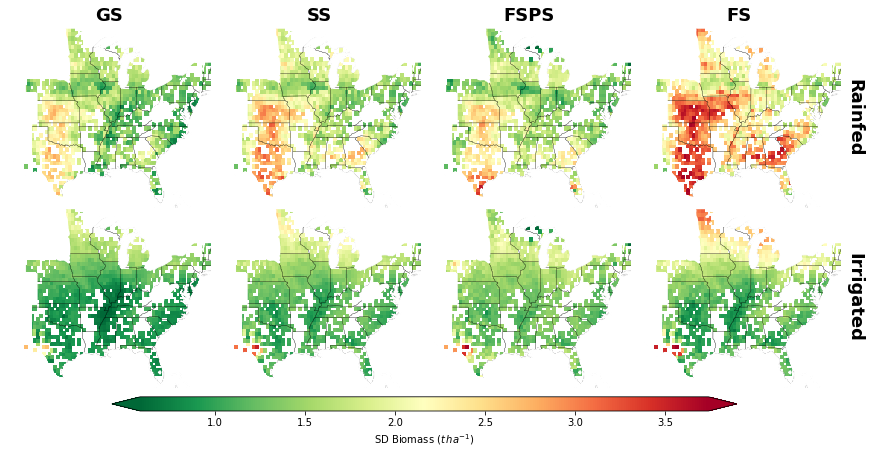

In [157]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).std()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.biomass2.std(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=a.biomass2.quantile(0.001),vmax=a.biomass2.quantile(0.999),
    figsize=(16,8), #rasterized=True,
    cmap=mpl.cm.RdYlGn_r,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='SD Biomass ($t\,ha^{-1}$)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\sd_biomass.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

cultivar  irr    lat     lon  Unnamed: 0  cropland_x  DaysAfterSowing  \
time                                                                          
17           0    1  27.25  -98.75         7.0        36.0            120.0   
19           0    1  27.25  -98.75         7.0        36.0            120.0   
19           0    1  27.75  -98.75        12.0        33.0            120.0   
19           0    1  28.75  -99.25        23.0        59.0            120.0   
19           0    1  29.75 -102.25        38.0        23.0            120.0   
...        ...  ...    ...     ...         ...         ...              ...   
13           3    2  46.25  -85.75      1045.0        38.0            120.0   
19           3    2  46.75  -95.75      1048.0        22.0            120.0   
19           3    2  46.75  -95.25      1049.0        23.0            120.0   
19           3    2  46.75  -94.75      1050.0        41.0            120.0   
19           3    2  47.25  -94.25      1057.0        53.0            120.0   

      FloweringDAS  IrrigationIn  LeafNo  ...   rain40DAS   rain80DAS  \
time                                      ...                           
17             0.0      0.000000   2.374  ...   12.924000   34.474998   
19             0.0      0.000000   1.961  ...    3.625000   14.225000   
19             0.0      0.000000   2.873  ...    6.400000   14.800000   
19             0.0      0.000000   3.748  ...    7.225000   31.350000   
19             0.0      0.000000   2.821  ...    7.600000   24.350000   
...            ...           ...     ...  ...         ...         ...   
13             0.0    119.780998   8.026  ...   96.497002  143.151001   
19             0.0    122.455002  13.505  ...  198.057007  207.847000   
19             0.0     98.197998  13.302  ...  177.630005  182.451004   
19             0.0     77.661003  13.370  ...  197.427994  149.531006   
19             0.0    125.058998  13.943  ...  174.380005  183.854996   

       rainHarv  scen  sw_stress_expan  sw_stress_photo  temp40DAS  temp80DAS  \
time                                                                            
17    40.950001   1.0            0.050            0.050  28.004000  30.292000   
19    29.975000   1.0            0.059            0.059  27.360001  31.747000   
19    43.099998   1.0            0.067            0.067  27.298000  31.726999   
19    61.583000   1.0            0.092            0.092  27.297001  32.146999   
19    34.226002   1.0            0.067            0.067  26.573000  31.768999   
...         ...   ...              ...              ...        ...        ...   
13    79.731003   4.0            0.983            0.983  13.308000  14.782000   
19    47.150002   4.0            0.983            0.983  15.213000  19.794001   
19    49.275002   4.0            0.983            0.983  15.438000  19.884001   
19    50.674999   4.0            0.983            0.983  15.648000  19.924000   
19    55.174999   4.0            0.983            0.983  15.361000  19.709999   

       tempHarv  biomass2  
time                       
17    31.471001    0.0217  
19    32.091000    0.0190  
19    32.077000    0.0262  
19    32.763000    0.0326  
19    32.452000    0.0246  
...         ...       ...  
13    15.748000    0.0383  
19    20.858999    0.0375  
19    20.599001    0.0398  
19    20.454000    0.0413  
19    20.246000    0.0369  

[2740 rows x 37 columns]

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-176-5fa7e6574eed>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


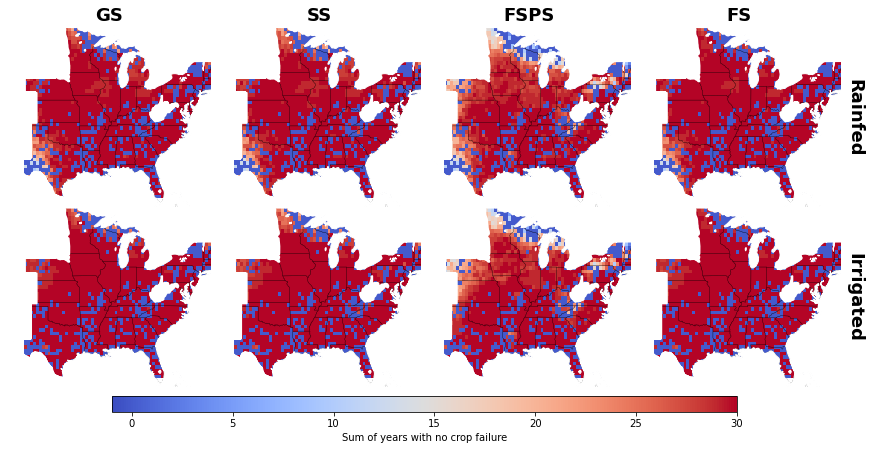

In [176]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).count()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.biomass2.count(dim=('time')).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1,vmax=30,
    figsize=(16,8),
    cmap=mpl.cm.coolwarm,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Sum of years with no crop failure')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\failures.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [54]:
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
a.FloweringDAS.max()

113.79310607910156

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-177-6de2647dad2f>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


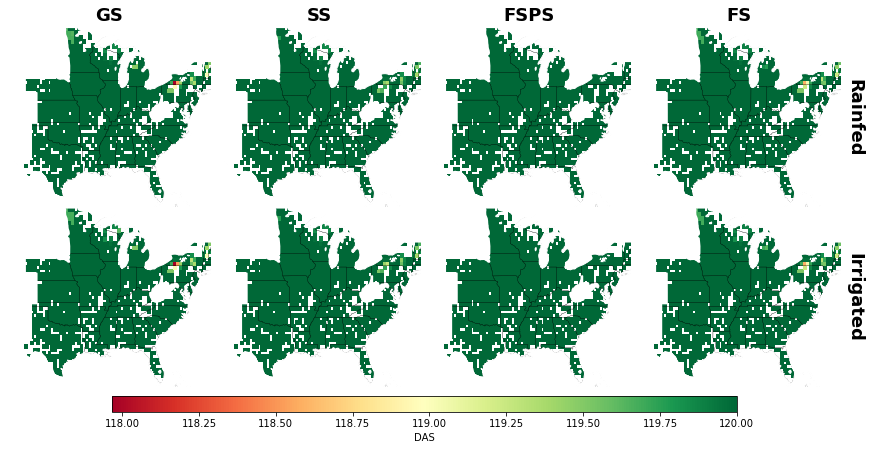

In [177]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.DaysAfterSowing.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=a.DaysAfterSowing.min(),vmax=a.DaysAfterSowing.max(),
    figsize=(16,8),
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='DAS')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\DAS.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-185-09f77f480880>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


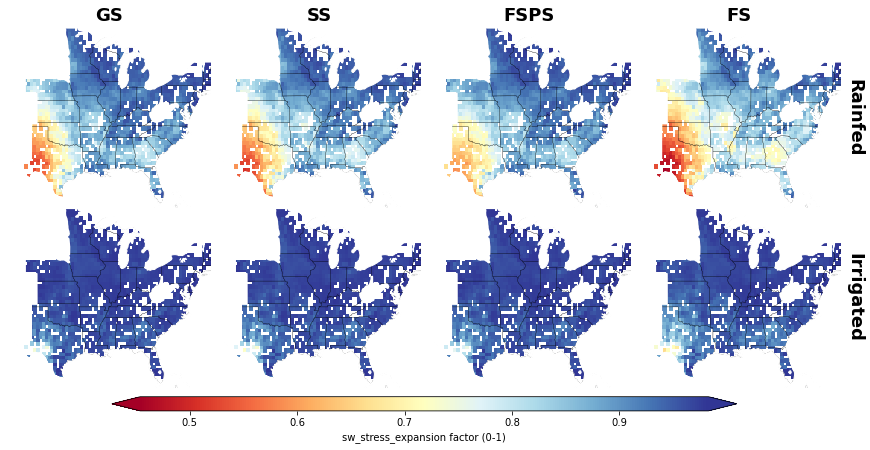

In [185]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.sw_stress_expan.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=a.sw_stress_expan.min(),vmax=a.sw_stress_expan.max(),
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='sw_stress_expansion factor (0-1)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\sw_stress_expan.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-57-761e56c75cec>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


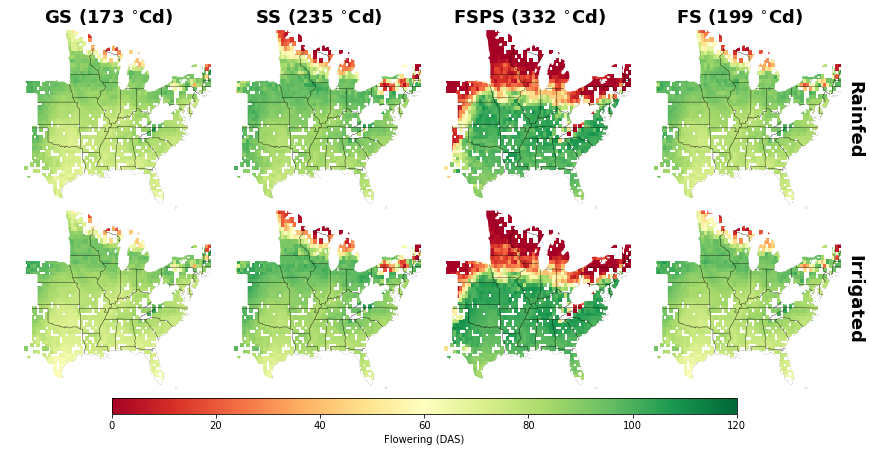

In [57]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.FloweringDAS.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=0,vmax=120,
    figsize=(16,8),
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Biomass ($kg\,ha^{-1}$)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS (173 $^{\circ}$Cd)", fontsize=18, fontweight="bold")
axes[1].set_title("SS (235 $^{\circ}$Cd)", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS (332 $^{\circ}$Cd)", fontsize=18, fontweight="bold")    
axes[3].set_title("FS (199 $^{\circ}$Cd)", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='Flowering (DAS)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\Flowering.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-58-ce73c7d4ca60>:74: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


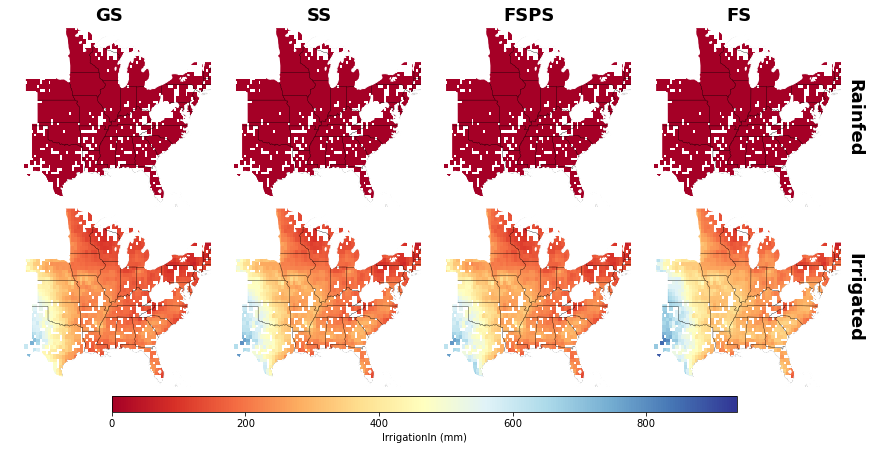

In [58]:
#Plotting mean biomass
a = df.groupby(['lat', 'lon','cultivar','irr'],as_index=False).mean()
map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.IrrigationIn.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', row='irr', col='cultivar',
    transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj},
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "IrrigationIn (mm)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=-0.2, hspace=0)
p.add_colorbar(orientation='horizontal', pad=0.02, shrink=0.7, aspect=40, label='IrrigationIn (mm)')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\IrrigationIn.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

## Work with 2D pandas dataframe and correlations

In [59]:
#Conver multidimendional frame to 2D frame
data4pd = data4.to_dataframe()
df = data4pd[data4pd.biomass != 0]
df.reset_index(level=[0,1,2,3,4], inplace=True)

#Change name of column
df.rename(columns={'scen_new':'cultivar'}, inplace=True)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-60-6ef0785f7fd7>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


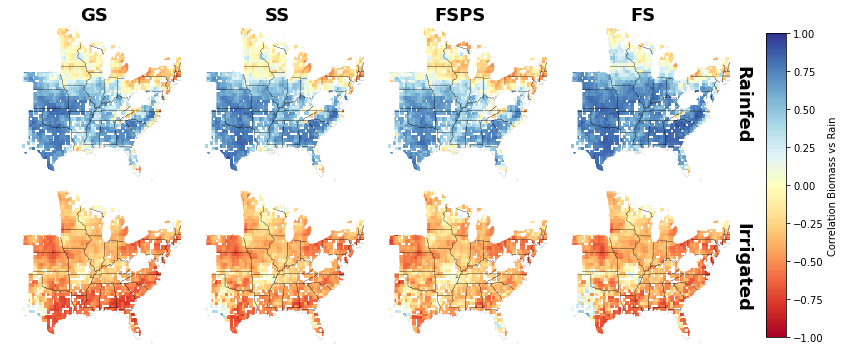

In [60]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='RainIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.RainIn.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Rain')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\raincorr.png', dpi=600, bbox_inches='tight', pad_inches=0)

hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-546-3eb4d2137bca>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


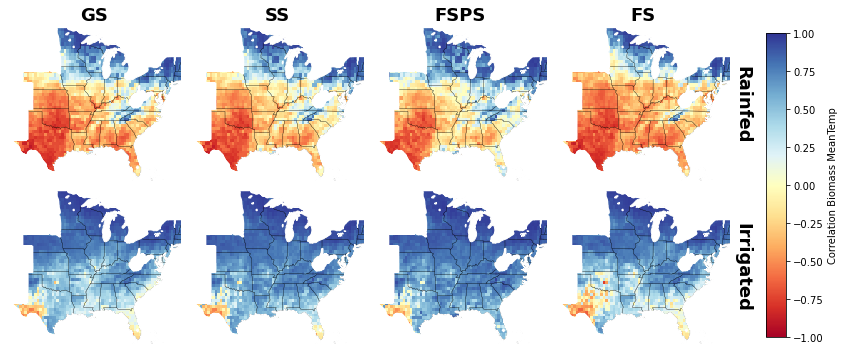

In [546]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='TempIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.TempIn.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass MeanTemp')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\tempcorr.png', dpi=600, bbox_inches='tight', pad_inches=0)

hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-321-2215da9b1e73>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


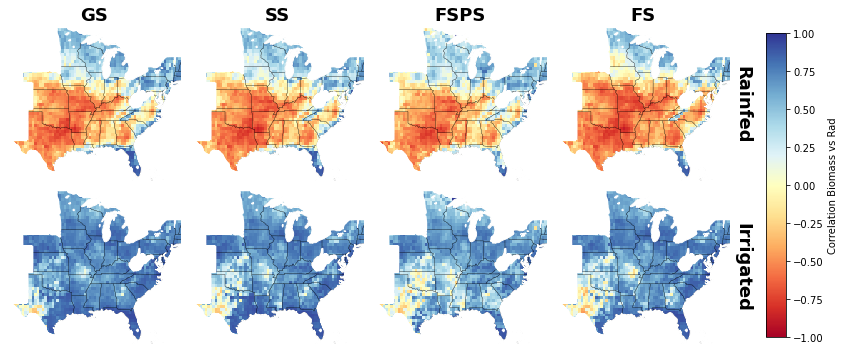

In [321]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='RadiationIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.RadiationIn.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Rad')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\radcorr.png', dpi=600, bbox_inches='tight', pad_inches=0)

hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-333-dcdbfcdebdb7>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)
C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


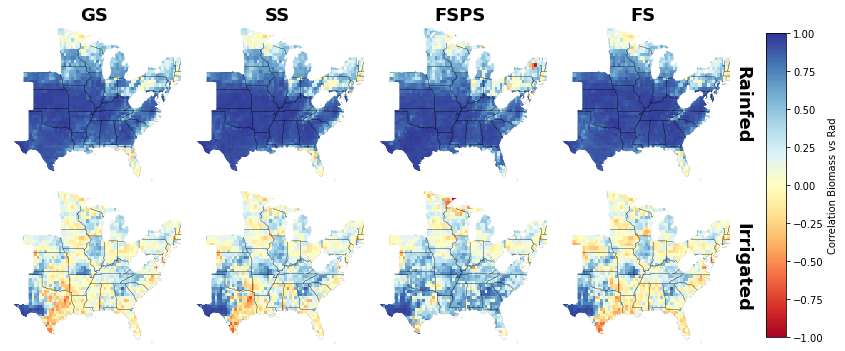

In [333]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='biomass'
x='sw_stress_expan'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.biomass.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Rad')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\biomass vs sw.png', dpi=600, bbox_inches='tight', pad_inches=0)

hide_toggle()

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-308-2b131e31ff70>:97: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


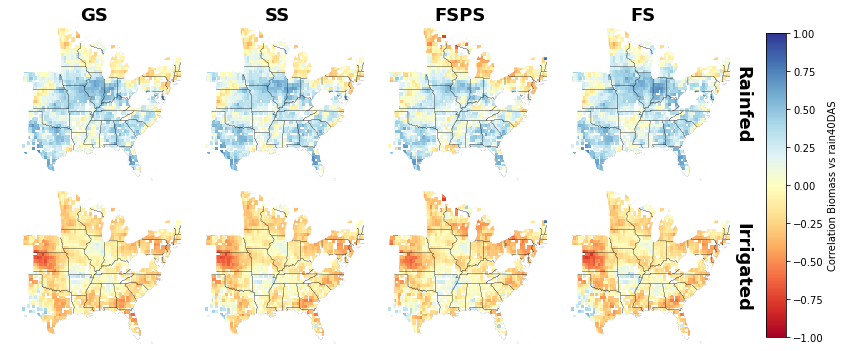

In [308]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='biomass'
x='rain40DAS'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.biomass.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs rain40DAS')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\biomass vs sw.png', dpi=600, bbox_inches='tight', pad_inches=0)

hide_toggle()

In [309]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='biomass'
x='PAWC'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.biomass.plot(x='lon', y='lat', col='cultivar', row='irr', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8),
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=-0.4)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs PAWC')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\biomass vs sw.png', dpi=600, bbox_inches='tight', pad_inches=0)

hide_toggle()

ValueError: Number of rows must be a positive integer, not 0

<Figure size 1152x576 with 0 Axes>

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-121-d1e2ef29f9a9>:99: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


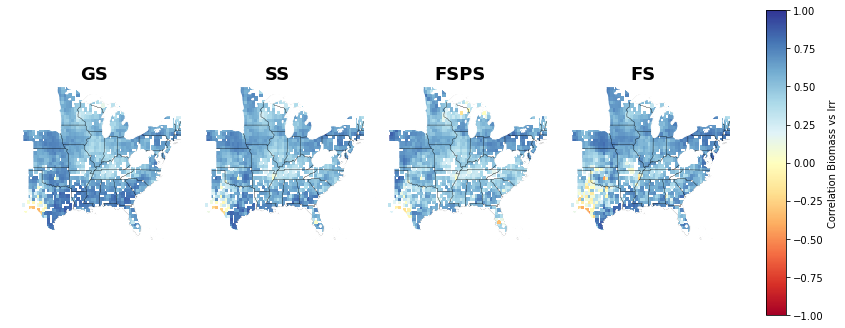

In [121]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='IrrigationIn'
x='biomass'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.IrrigationIn.plot(x='lon', y='lat', col='cultivar', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=0)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Correlation Biomass vs Irr')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\irricorr.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

In [122]:
e

IrrigationIn
lat   lon    cultivar irr              
26.25 -99.25 0        2        0.842392
             1        2        0.864040
             2        2        0.231602
             3        2        0.871531
      -98.25 0        2        0.556680
...                                 ...
48.75 -94.25 3        2        0.731229
      -93.75 0        2        0.393011
             1        2        0.443667
             2        2        0.144530
             3        2        0.678377

[5308 rows x 1 columns]

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()
<ipython-input-32-62b63096f234>:99: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  ax.outline_patch.set_visible(False)


C:\Users\uqjojeda\Anaconda3\lib\site-packages\cartopy\mpl\style.py:90: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


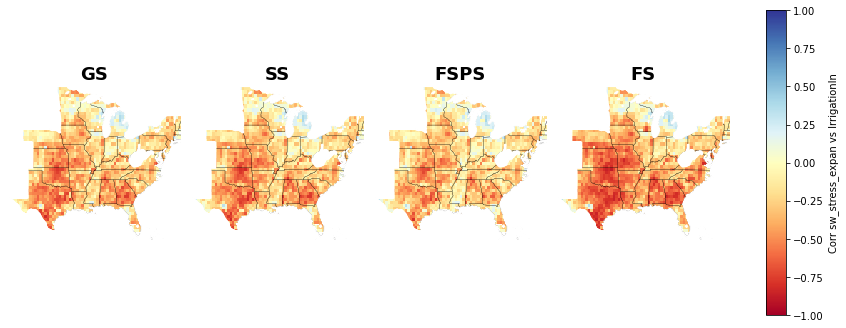

In [32]:
#Calculate correlation between defined variables (specify y variable!!!!!!)
y='sw_stress_expan'
x='IrrigationIn'

#Set index
dfa = df.set_index(['lat','lon','cultivar','irr'])

a=dfa.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4'], axis=1)
#Drop duplicates
e = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Set indexes
e.set_index(['lat', 'lon', 'cultivar', 'irr'], inplace=True)

#From 2D dataframe to xarray
corr = e.to_xarray()

#Plotting standar deviation of biomass (specify name of variable to plot!!!!! p = corr."TempIn".plot)

map_proj = ccrs.Mercator(central_longitude=-95)

p = corr.sw_stress_expan.plot(x='lon', y='lat', col='cultivar', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=-1, vmax=1,
    figsize=(16,8), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "correlation"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr,
                              alpha = 1.00, linewidth =3, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

def area2(ax, iso, clr, z) :
    
    shp = shpreader.natural_earth(resolution='110m',category='cultural', name='admin_1_states_provinces_lakes_shp')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['postal'] == iso: 
            try:
                ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, zorder=z,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
            except Exception as e:
                #print(e)
                import shapely.wkt as wkt
                from shapely.geometry import MultiPolygon
                list_str_polygons = [str(n.geometry)]
                c = MultiPolygon(map(wkt.loads, list_str_polygons))
                ax.add_geometries(c, ccrs.PlateCarree(), facecolor=clr,
                                  alpha = 1.00, linewidth =2, edgecolor = "white",
                                  label=n.attributes['postal']) 
    return ax

iso4 = ['NM','CO','WY','ND','SD', 'WV', 'MT']

#Edit title of columns and rows
axes = p.axes.flatten()
axes[0].set_title("GS", fontsize=18, fontweight="bold")
axes[1].set_title("SS", fontsize=18, fontweight="bold")
axes[2].set_title("FSPS", fontsize=18, fontweight="bold")    
axes[3].set_title("FS", fontsize=18, fontweight="bold")

irri_labels =  ["","","","Rainfed","","","","Irrigated"]

for i, ax in enumerate(p.axes.flat):
    plt.setp(ax.texts, text=irri_labels[i], fontsize=18, fontweight="bold")

#Edit other features of the map
for ax in p.axes.flat:
    gl=ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', 
                    draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.COASTLINE, edgecolor = "grey", linewidth=1)
    ax.add_feature(cfeature.STATES, edgecolor = "k", linewidth=0.2, zorder=1)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.add_feature(cfeature.BORDERS, edgecolor = "grey", color='grey', linewidth=1)
    ax.set_extent([-107, -72, 24.5, 49], crs=ccrs.PlateCarree())
    ax.outline_patch.set_visible(False)
    gl.top_labels = False
    gl.right_labels = False

    gl.xlocator = mticker.FixedLocator([-100, -90, -80])
    gl.ylocator = mticker.FixedLocator([30, 35,40, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}

    for value in iso4 :
        area2(ax, value, "white", 4)

    area2(ax, value, "white", 4)

    for value in iso3 :
        area(ax, value, "white")

    area(ax, value, "white")
    
#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0.05, hspace=0)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=15, label='Corr sw_stress_expan vs IrrigationIn')

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\sw vs Irri.png', dpi=600, bbox_inches='tight', pad_inches=0)
hide_toggle()

## Heatmap and correlations

In [73]:
#Read dataframe with env names
X= pd.read_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\dfenv.csv')

#Merge current dataset to include envs
new = pd.merge(X, df, how ='inner', on =['lat','lon']) 
dfa=new.drop(['rain_a', 'radn_a', 'rain_b', 'radn_b', 'rain_c',
       'radn_c', 'wind_a', 'hur_a', 'hurtmax_a', 'cropland_a', 'tmax_a',
       'tmin_a', 'tmean_a', 'wind_b', 'hur_b', 'hurtmax_b', 'cropland_b',
       'tmax_b', 'tmin_b', 'tmean_b', 'wind_c', 'hur_c', 'hurtmax_c',
       'cropland_c', 'tmax_c', 'tmin_c', 'tmean_c', 'radn', 'rain', 'tmin',
       'tmax', 'tmean', 'wind', 'hur', 'hurtmax', 'cropland',
       'Unnamed: 0','env_name_y'], axis=1)

dfa.rename(columns={'env_name_x':'env_name','cropland_x':'cropland'}, inplace=True)
dfa3 = dfa.dropna()

In [74]:
a = dfa3.loc[dfa3['irr'] ==2]
a.IrrigationIn.describe()

count    156202.000000
mean        288.543335
std         172.708237
min           0.000000
25%         160.161247
50%         254.733498
75%         382.892754
max        1296.145020
Name: IrrigationIn, dtype: float64

In [77]:
#Export data for Variance Decomposition Analysis
dfa = dfa3.dropna()
var1 = dfa.groupby(['env_name','irr', 'lat', 'lon', 'cultivar'],as_index=False).mean()

var=var1.drop(['DaysAfterSowing', 'planting_date', 'scen','aMaxT','aMinT','IrrigationIn','FloweringDAS','biomass2'], axis=1)

#var.to_csv(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\data\var.csv')

In [81]:
dfa3.env_name.unique()

array(['West', 'South', 'Mid', 'North'], dtype=object)

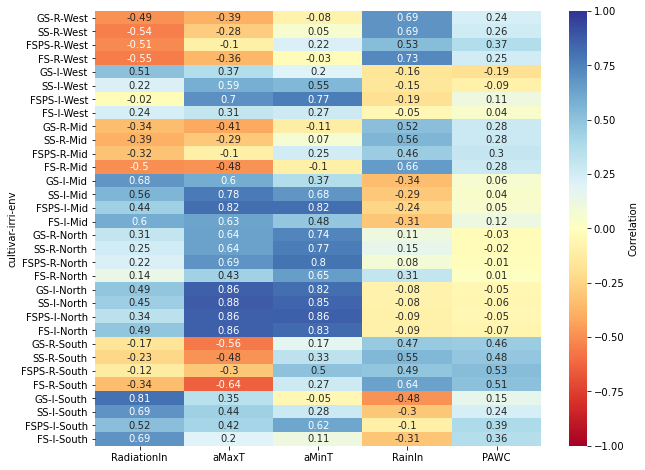

In [82]:
#Create filters and rearrange dataframes
A = dfa3.loc[dfa3['env_name'] == 'West']
B = dfa3.loc[dfa3['env_name'] == 'Mid']
C = dfa3.loc[dfa3['env_name'] == 'North']
D = dfa3.loc[dfa3['env_name'] == 'South']

Adry = A.loc[A['irr'] == 1]
Airri = A.loc[A['irr'] == 2]
Bdry = B.loc[B['irr'] == 1]
Birri = B.loc[B['irr'] == 2]
Cdry = C.loc[C['irr'] == 1]
Cirri = C.loc[C['irr'] == 2]
Ddry = D.loc[D['irr'] == 1]
Dirri = D.loc[D['irr'] == 2]

AGSd = Adry.loc[Adry['cultivar'] == 0]
ASSd = Adry.loc[Adry['cultivar'] == 1]
AFSPSd = Adry.loc[Adry['cultivar'] == 2]
AFSd = Adry.loc[Adry['cultivar'] == 3]
AGSi = Airri.loc[Airri['cultivar'] == 0]
ASSi = Airri.loc[Airri['cultivar'] == 1]
AFSPSi = Airri.loc[Airri['cultivar'] == 2]
AFSi = Airri.loc[Airri['cultivar'] == 3]

BGSd = Bdry.loc[Bdry['cultivar'] == 0]
BSSd = Bdry.loc[Bdry['cultivar'] == 1]
BFSPSd = Bdry.loc[Bdry['cultivar'] == 2]
BFSd = Bdry.loc[Bdry['cultivar'] == 3]
BGSi = Birri.loc[Birri['cultivar'] == 0]
BSSi = Birri.loc[Birri['cultivar'] == 1]
BFSPSi = Birri.loc[Birri['cultivar'] == 2]
BFSi = Birri.loc[Birri['cultivar'] == 3]

CGSd = Cdry.loc[Cdry['cultivar'] == 0]
CSSd = Cdry.loc[Cdry['cultivar'] == 1]
CFSPSd = Cdry.loc[Cdry['cultivar'] == 2]
CFSd = Cdry.loc[Cdry['cultivar'] == 3]
CGSi = Cirri.loc[Cirri['cultivar'] == 0]
CSSi = Cirri.loc[Cirri['cultivar'] == 1]
CFSPSi = Cirri.loc[Cirri['cultivar'] == 2]
CFSi = Cirri.loc[Cirri['cultivar'] == 3]

DGSd = Ddry.loc[Ddry['cultivar'] == 0]
DSSd = Ddry.loc[Ddry['cultivar'] == 1]
DFSPSd = Ddry.loc[Ddry['cultivar'] == 2]
DFSd = Ddry.loc[Ddry['cultivar'] == 3]
DGSi = Dirri.loc[Dirri['cultivar'] == 0]
DSSi = Dirri.loc[Dirri['cultivar'] == 1]
DFSPSi = Dirri.loc[Dirri['cultivar'] == 2]
DFSi = Dirri.loc[Dirri['cultivar'] == 3]

AGSdcorr = AGSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
AGSdcorr['cultivar'] = 'GS'
AGSdcorr['irri'] = 'R'
AGSdcorr['env'] = 'West'
AFSdcorr = AFSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
AFSdcorr['cultivar'] = 'FS'
AFSdcorr['irri'] = 'R'
AFSdcorr['env'] = 'West'
ASSdcorr = ASSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
ASSdcorr['cultivar'] = 'SS'
ASSdcorr['irri'] = 'R'
ASSdcorr['env'] = 'West'
AFSPSdcorr = AFSPSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
AFSPSdcorr['cultivar'] = 'FSPS'
AFSPSdcorr['irri'] = 'R'
AFSPSdcorr['env'] = 'West'

AGSicorr = AGSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
AGSicorr['cultivar'] = 'GS'
AGSicorr['irri'] = 'I'
AGSicorr['env'] = 'West'
AFSicorr = AFSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
AFSicorr['cultivar'] = 'FS'
AFSicorr['irri'] = 'I'
AFSicorr['env'] = 'West'
ASSicorr = ASSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
ASSicorr['cultivar'] = 'SS'
ASSicorr['irri'] = 'I'
ASSicorr['env'] = 'West'
AFSPSicorr = AFSPSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
AFSPSicorr['cultivar'] = 'FSPS'
AFSPSicorr['irri'] = 'I'
AFSPSicorr['env'] = 'West'

BGSdcorr = BGSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BGSdcorr['cultivar'] = 'GS'
BGSdcorr['irri'] = 'R'
BGSdcorr['env'] = 'Mid'
BFSdcorr = BFSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BFSdcorr['cultivar'] = 'FS'
BFSdcorr['irri'] = 'R'
BFSdcorr['env'] = 'Mid'
BSSdcorr = BSSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BSSdcorr['cultivar'] = 'SS'
BSSdcorr['irri'] = 'R'
BSSdcorr['env'] = 'Mid'
BFSPSdcorr = BFSPSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BFSPSdcorr['cultivar'] = 'FSPS'
BFSPSdcorr['irri'] = 'R'
BFSPSdcorr['env'] = 'Mid'

BGSicorr = BGSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BGSicorr['cultivar'] = 'GS'
BGSicorr['irri'] = 'I'
BGSicorr['env'] = 'Mid'
BFSicorr = BFSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BFSicorr['cultivar'] = 'FS'
BFSicorr['irri'] = 'I'
BFSicorr['env'] = 'Mid'
BSSicorr = BSSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BSSicorr['cultivar'] = 'SS'
BSSicorr['irri'] = 'I'
BSSicorr['env'] = 'Mid'
BFSPSicorr = BFSPSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
BFSPSicorr['cultivar'] = 'FSPS'
BFSPSicorr['irri'] = 'I'
BFSPSicorr['env'] = 'Mid'

CGSdcorr = CGSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CGSdcorr['cultivar'] = 'GS'
CGSdcorr['irri'] = 'R'
CGSdcorr['env'] = 'North'
CFSdcorr = CFSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CFSdcorr['cultivar'] = 'FS'
CFSdcorr['irri'] = 'R'
CFSdcorr['env'] = 'North'
CSSdcorr = CSSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CSSdcorr['cultivar'] = 'SS'
CSSdcorr['irri'] = 'R'
CSSdcorr['env'] = 'North'
CFSPSdcorr = CFSPSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CFSPSdcorr['cultivar'] = 'FSPS'
CFSPSdcorr['irri'] = 'R'
CFSPSdcorr['env'] = 'North'

CGSicorr = CGSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CGSicorr['cultivar'] = 'GS'
CGSicorr['irri'] = 'I'
CGSicorr['env'] = 'North'
CFSicorr = CFSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CFSicorr['cultivar'] = 'FS'
CFSicorr['irri'] = 'I'
CFSicorr['env'] = 'North'
CSSicorr = CSSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CSSicorr['cultivar'] = 'SS'
CSSicorr['irri'] = 'I'
CSSicorr['env'] = 'North'
CFSPSicorr = CFSPSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
CFSPSicorr['cultivar'] = 'FSPS'
CFSPSicorr['irri'] = 'I'
CFSPSicorr['env'] = 'North'

DGSdcorr = DGSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DGSdcorr['cultivar'] = 'GS'
DGSdcorr['irri'] = 'R'
DGSdcorr['env'] = 'South'
DFSdcorr = DFSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DFSdcorr['cultivar'] = 'FS'
DFSdcorr['irri'] = 'R'
DFSdcorr['env'] = 'South'
DSSdcorr = DSSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DSSdcorr['cultivar'] = 'SS'
DSSdcorr['irri'] = 'R'
DSSdcorr['env'] = 'South'
DFSPSdcorr = DFSPSd.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DFSPSdcorr['cultivar'] = 'FSPS'
DFSPSdcorr['irri'] = 'R'
DFSPSdcorr['env'] = 'South'

DGSicorr = DGSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DGSicorr['cultivar'] = 'GS'
DGSicorr['irri'] = 'I'
DGSicorr['env'] = 'South'
DFSicorr = DFSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DFSicorr['cultivar'] = 'FS'
DFSicorr['irri'] = 'I'
DFSicorr['env'] = 'South'
DSSicorr = DSSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DSSicorr['cultivar'] = 'SS'
DSSicorr['irri'] = 'I'
DSSicorr['env'] = 'South'
DFSPSicorr = DFSPSi.corr().loc[['biomass'],['RadiationIn','aMaxT','aMinT','RainIn','PAWC']]
DFSPSicorr['cultivar'] = 'FSPS'
DFSPSicorr['irri'] = 'I'
DFSPSicorr['env'] = 'South'

frames = [AGSdcorr,ASSdcorr,AFSPSdcorr,AFSdcorr,AGSicorr,ASSicorr,AFSPSicorr,AFSicorr,
          BGSdcorr,BSSdcorr,BFSPSdcorr,BFSdcorr,BGSicorr,BSSicorr,BFSPSicorr,BFSicorr,
          CGSdcorr,CSSdcorr,CFSPSdcorr,CFSdcorr,CGSicorr,CSSicorr,CFSPSicorr,CFSicorr,
          DGSdcorr,DSSdcorr,DFSPSdcorr,DFSdcorr,DGSicorr,DSSicorr,DFSPSicorr,DFSicorr]

corr = pd.concat(frames)
corr.reset_index(level=[0], inplace=True)

df_final=corr.drop(['index'], axis=1)
df1 = df_final.set_index(['cultivar','irri','env'])
df2 = df1.round(decimals=2)

#Plot heatmap
fig= plt.figure(figsize=(10,8))
sns.heatmap(df2, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\figs\corr.png', dpi=300, bbox_inches='tight', pad_inches=0)

hide_toggle()

In [83]:
df_corr = df2.reset_index()

In [86]:
df_corr2 = df_corr.set_index(['cultivar','irri'])

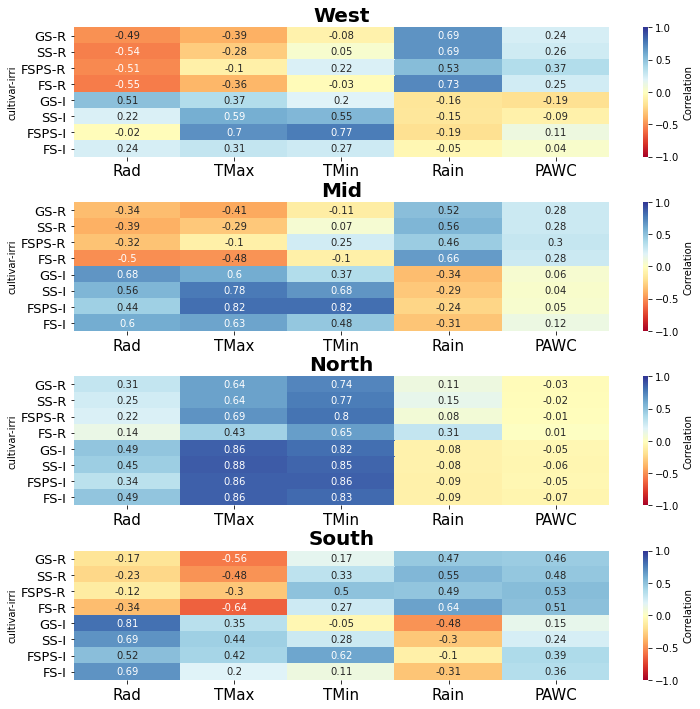

In [91]:
df_corr2.rename(columns={'RadiationIn':'Rad','aMaxT':'TMax','aMinT':'TMin',
                        'RainIn':'Rain','actual_ET':'ET','IrrigationIn':'Irr','radInt':'RadInt'}, inplace=True)

A = df_corr2.loc[df_corr2['env'] == 'West']
A2 = A.drop(['env'], axis=1)
B = df_corr2.loc[df_corr2['env'] == 'Mid']
B2 = B.drop(['env'], axis=1)
C = df_corr2.loc[df_corr2['env'] == 'North']
C2 = C.drop(['env'], axis=1)
D = df_corr2.loc[df_corr2['env'] == 'South']
D2 = D.drop(['env'], axis=1)

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12,12))
sns.heatmap(A2, ax=ax1, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})
sns.heatmap(B2, ax=ax2, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})
sns.heatmap(C2, ax=ax3, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})
sns.heatmap(D2, ax=ax4, annot=True, cmap='RdYlBu',vmin=-1, vmax=1,
        cbar_kws={
        "orientation": "vertical",
        "shrink": 1,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Correlation"})

ax1.set_title('West', fontweight='bold', size=20)
ax1.xaxis.set_tick_params(labelsize=15)
ax1.yaxis.set_tick_params(labelsize=13)

ax2.set_title('Mid', fontweight='bold', size=20)
ax2.xaxis.set_tick_params(labelsize=15)
ax2.yaxis.set_tick_params(labelsize=13)

ax3.set_title('North', fontweight='bold', size=20)
ax3.xaxis.set_tick_params(labelsize=15)
ax3.yaxis.set_tick_params(labelsize=13)

ax4.set_title('South', fontweight='bold', size=20)
ax4.xaxis.set_tick_params(labelsize=15)
ax4.yaxis.set_tick_params(labelsize=13)

plt.subplots_adjust(wspace=0, hspace=0.35)
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\corr.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

## Others

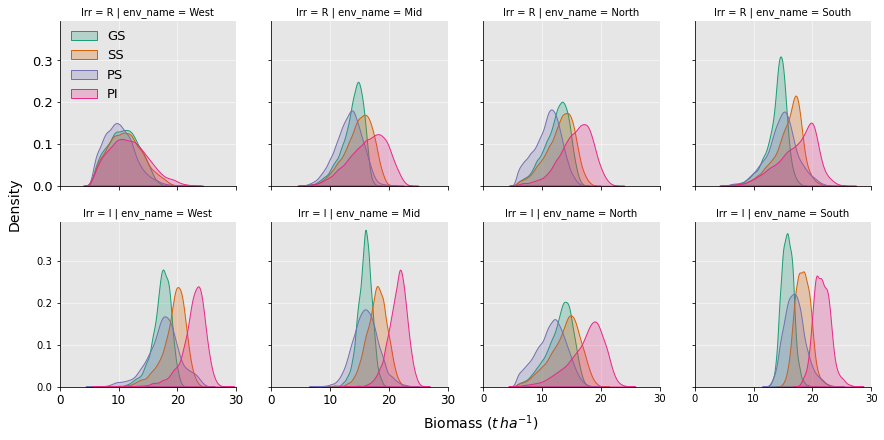

In [102]:
#Density plot#

dfa3.loc[dfa3.cultivar == 0, 'cv'] = "GS"
dfa3.loc[dfa3.cultivar == 1, 'cv'] = "SS"
dfa3.loc[dfa3.cultivar == 2, 'cv'] = "PS"
dfa3.loc[dfa3.cultivar == 3, 'cv'] = "PI"

dfa3.loc[dfa3.irr == 1, 'Irr'] = "R"
dfa3.loc[dfa3.irr == 2, 'Irr'] = "I"

g = sns.FacetGrid(dfa3, col="env_name", row='Irr', hue="cv",hue_order= ['GS','SS','PS','PI'], col_order=['West','Mid','North','South'], sharey=True, height=3,
                  aspect=1, palette='Dark2')

g.map(sns.kdeplot,"biomass2",shade=True, zorder=2)

g.add_legend(fontsize=13,title=False,bbox_to_anchor=(0.13, 0.84))
g.set_xlabels("")
axes = g.axes.flatten()

axes[0].yaxis.set_tick_params(labelsize=13)
axes[3].yaxis.set_tick_params(labelsize=13)
axes[3].set_xlim(0,30)
axes[3].xaxis.set_tick_params(labelsize=12)
axes[3].xaxis.set_major_locator(ticker.MultipleLocator(10))
axes[4].set_xlim(0,30)
axes[4].xaxis.set_tick_params(labelsize=12)
axes[4].xaxis.set_major_locator(ticker.MultipleLocator(10))
axes[5].set_xlim(0,30)
axes[5].xaxis.set_tick_params(labelsize=12)
axes[5].xaxis.set_major_locator(ticker.MultipleLocator(10))

axes[0].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[0].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[0].patch.set_facecolor('0.90')
axes[1].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[1].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[1].patch.set_facecolor('0.90')
axes[2].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[2].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[2].patch.set_facecolor('0.90')
axes[3].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[3].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[3].patch.set_facecolor('0.90')
axes[4].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[4].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[4].patch.set_facecolor('0.90')
axes[5].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[5].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[5].patch.set_facecolor('0.90')
axes[6].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[6].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[6].patch.set_facecolor('0.90')
axes[7].grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
axes[7].grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
axes[7].patch.set_facecolor('0.90')

g.fig.text(0.5, 0, 'Biomass ($t\,ha^{-1}$)', ha='center', fontsize =14)
g.fig.text(-0.01, 0.52, 'Density', va='center', rotation='vertical', fontsize =14)
g.fig.subplots_adjust(wspace=0.2, hspace=0.22)

#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\paper\figs\density.png', dpi=300, bbox_inches='tight', pad_inches=0)
hide_toggle()

<ipython-input-42-dd75683abfc7>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(),rotation=90)


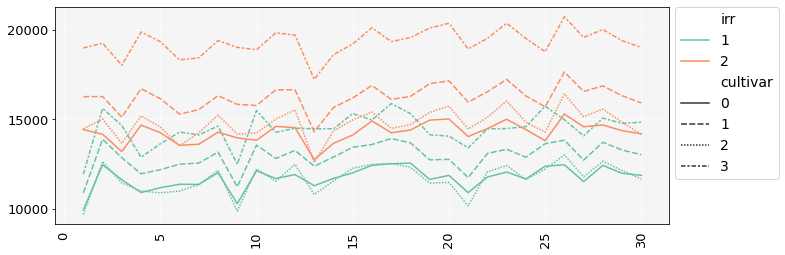

In [42]:
#Biomass vs year#

fig= plt.figure(figsize=(11,4))

ax=plt.subplot(1, 1, 1)

ax = sns.lineplot(x="time", y="biomass",hue="irr", style="cultivar", estimator=np.mean, data=df,
                  ci=95, err_style="band", palette='Set2')

# Formatting graph and background
plt.legend(prop=dict(size=14),bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)
plt.ylabel('', fontsize =15)
plt.xlabel('', fontsize =25)
ax = plt.gca()
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.5)
ax.grid(True, 'minor', color='0.92', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('0.96')
ax.set_axisbelow(True)
ax.yaxis.set_tick_params(labelsize=13)
ax.xaxis.set_tick_params(labelsize=13)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
ax.yaxis.set_major_locator(ticker.MultipleLocator(5000))
#ax.set_ylim([10.1,21.9])
#ax.set_xlim([1979.5,2009.5])
plt.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)

In [103]:
dfa3.columns

Index(['lat', 'lon', 'env', 'env_name', 'cultivar', 'irr', 'time', 'cropland',
       'DaysAfterSowing', 'FloweringDAS', 'IrrigationIn', 'LeafNo', 'MaxLAI',
       'N_stress_expan', 'N_stress_photo', 'PAWC', 'RadiationIn', 'RainIn',
       'TempIn', 'WU', 'aMaxT', 'aMinT', 'actual_ET', 'biomass',
       'planting_date', 'potential_ET', 'rad40DAS', 'rad80DAS', 'radHarv',
       'rain40DAS', 'rain80DAS', 'rainHarv', 'scen', 'sw_stress_expan',
       'sw_stress_photo', 'temp40DAS', 'temp80DAS', 'tempHarv', 'biomass2',
       'cv', 'Irr'],
      dtype='object')

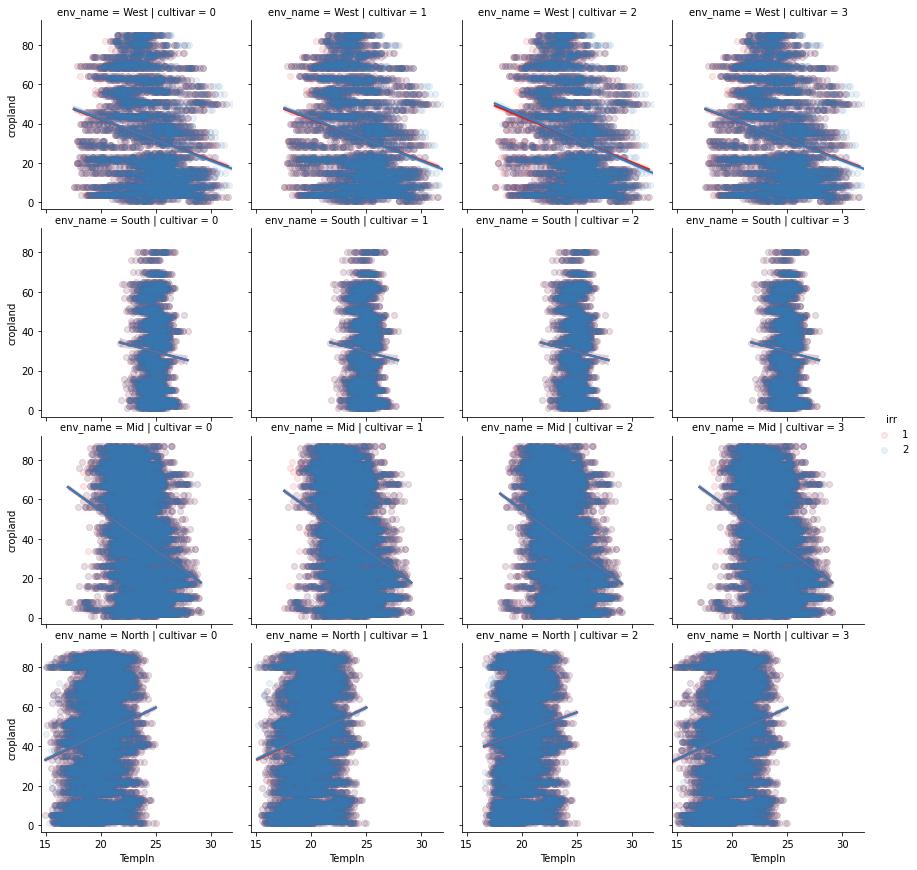

In [119]:
dfa3['AET/ET0'] = dfa3['actual_ET']/dfa3['potential_ET']
sns.lmplot(x="TempIn", y="cropland",hue='irr',row='env_name',col='cultivar', data=dfa3, palette='Set1',scatter_kws={'alpha':0.1}, height=3)
plt.subplots_adjust(wspace=0.1, hspace=0.1)

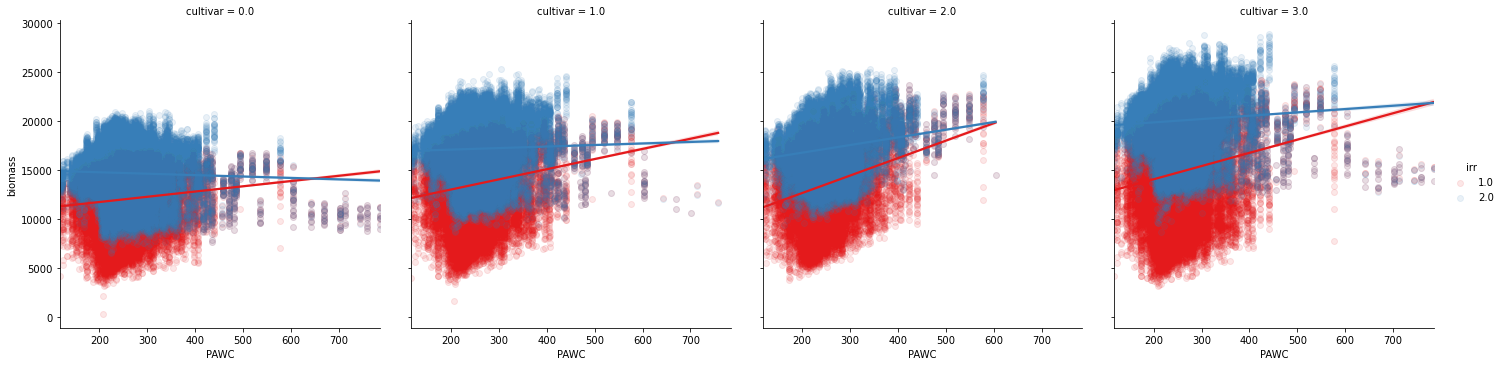

In [44]:
sns.lmplot(x="PAWC", y="biomass",hue='irr',col='cultivar', data=df_flo, palette='Set1',scatter_kws={'alpha':0.1})
plt.subplots_adjust(wspace=0.1, hspace=0)

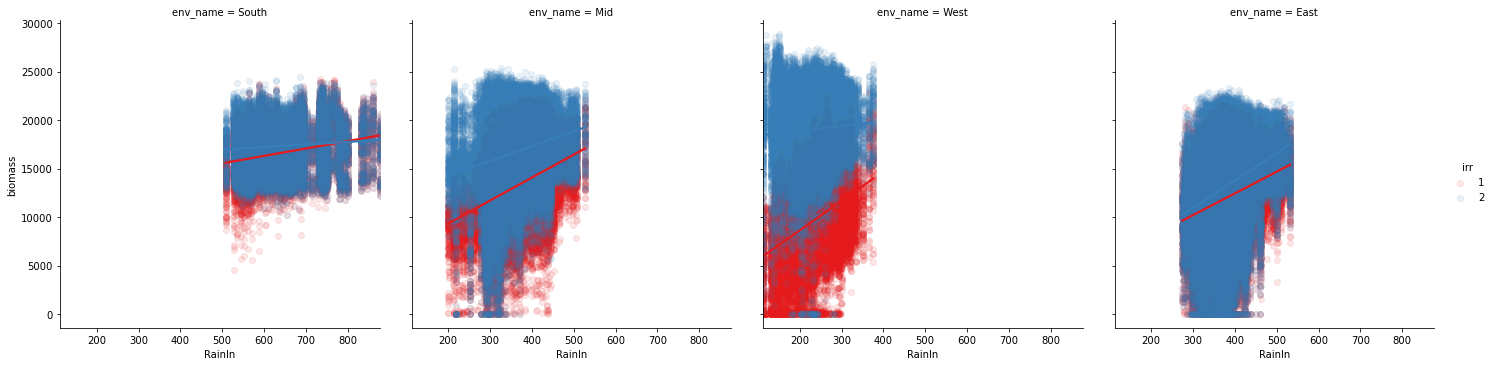

In [50]:
sns.lmplot(x="RainIn", y="biomass",hue='irr',col='env_name', data=dfa3, palette='Set1',scatter_kws={'alpha':0.1})
plt.subplots_adjust(wspace=0.1, hspace=0)

<AxesSubplot:xlabel='cultivar', ylabel='FloweringDAS'>

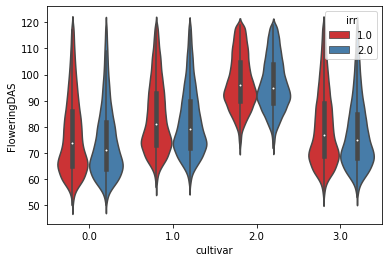

In [46]:
kwargs  =   {'edgecolor':"k"}
sns.violinplot(x="cultivar", y="FloweringDAS",hue='irr', data=df_flo, palette='Set1')

In [47]:
#sns.pairplot(df_mean, hue='cultivar', vars=['biomass', 'yield','IrrigationIn', 'FloweringDAS', 'MaxLAI', 'RainIn', 'TempIn', 'RadiationIn',
#       'WaterUse', 'actual_ET'])

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


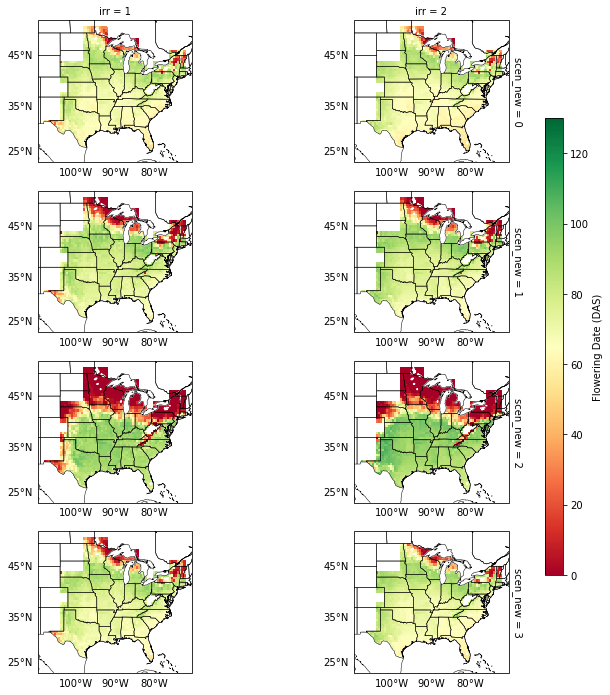

In [51]:
#Plotting FloweringDas

map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.FloweringDAS.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=0, vmax=130,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Flowering Date (DAS)"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
for value in iso3 :
    area(ax, value, "white")
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


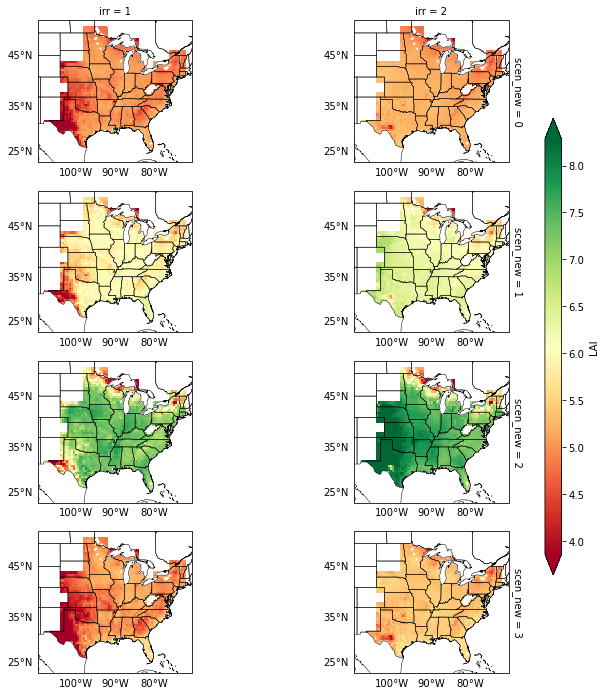

In [52]:
#Plotting MaxLAI

map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.MaxLAI.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, #vmin=7000, vmax=20000,
    figsize=(13,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "LAI"}, zorder=1)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=True,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    area(ax, value, "white")
    gl.top_labels = False
    gl.left_labels = True
    gl.right_labels =False
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator([-120, -110, -100, -90, -80])
    gl.ylocator = mticker.FixedLocator([25, 35, 45])
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10, 'color': 'k'}
    gl.ylabel_style = {'size': 10, 'color': 'k'}
    
for value in iso3 :
    area(ax, value, "white")
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

C:\Users\uqjojeda\Anaconda3\lib\site-packages\xarray\plot\facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


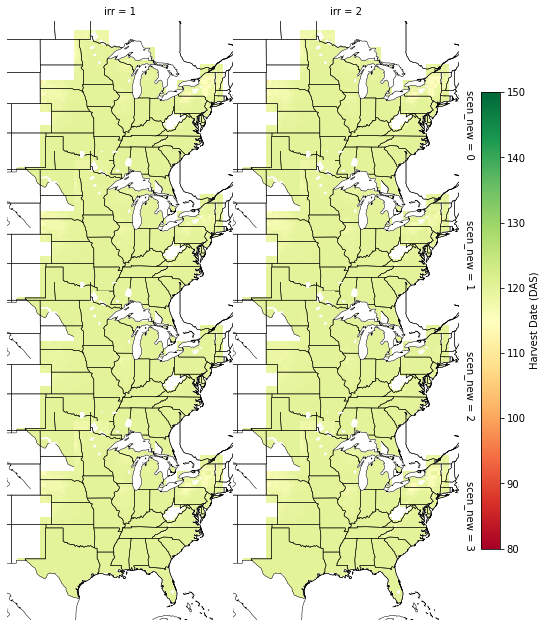

In [53]:
#Plotting biomass

map_proj = ccrs.Mercator(central_longitude=-95)

p = data4.DaysAfterSowing.mean(dim=('time'), skipna=True).plot(x='lon', y='lat', col='irr', row='scen_new', transform=ccrs.PlateCarree(central_longitude=0),
    subplot_kws={'projection': map_proj}, vmin=80, vmax=150,
    figsize=(10,12), #rasterized=True
    # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlGn,
    cbar_kwargs={
        "orientation": "vertical",
        "shrink": 0.7,
        "aspect": 25,
        "pad": 0.05, #distance of colorbar to plot
        "label": "Harvest Date (DAS)"}, zorder=1, add_colorbar=False, label=False)

def area(ax, iso, clr) :
    shp = shpreader.natural_earth(resolution='10m',category='cultural',
                                  name='admin_0_countries')
    reader = shpreader.Reader(shp)
    for n in reader.records() :
        if n.attributes['ADM0_A3'] == iso: 
            ax.add_geometries(n.geometry, ccrs.PlateCarree(), facecolor=clr, 
                              alpha = 1.00, linewidth =0.01, edgecolor = "white",
                              label=n.attributes['ADM0_A3']) 
    return ax

iso3 = ['CAN', 'MEX']

for value in iso3 :
    area(ax, value, "white")

for ax in p.axes.flat:
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.01, color='w', alpha=0, linestyle='-', draw_labels=False,dms=True, x_inline=False, y_inline=False)
    ax.coastlines(color='black',linewidth=0.5, zorder=4)
    ax.add_feature(cfeature.STATES,linewidth=0.5, zorder=3)
    ax.add_feature(cfeature.OCEAN, color='white', zorder=2)
    ax.add_feature(cfeature.LAKES, color='white', zorder=1.5)
    ax.axis("off")
    area(ax, value, "white")
#    gl.top_labels = False
#    gl.left_labels = True
#    gl.right_labels =False
#    gl.xlines = False
#    gl.ylines = False
#    gl.xlocator = mticker.FixedLocator([]) #-120, -100, -80
#    gl.ylocator = mticker.FixedLocator([]) #25, 35, 45
#    gl.xformatter = LONGITUDE_FORMATTER
#    gl.yformatter = LATITUDE_FORMATTER
#    gl.xlabel_style = {'size': 10, 'color': 'k'}
#    gl.ylabel_style = {'size': 10, 'color': 'k'}

#Adjust colorbar and subplots
plt.subplots_adjust(wspace=0, hspace=-0.5)
p.add_colorbar(orientation='vertical', pad=0.04, shrink=0.7, aspect=25, label='Harvest Date (DAS)')
    
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\seminars\20201214 UQ meeting\figs\biomass_all.png', dpi=300, bbox_inches='tight', pad_inches=0)

In [ ]:
sns.lmplot(x="TempIn", y="DaysAfterSowing",hue='irr',col='cultivar', data=df_flo, palette='Set1',scatter_kws={'alpha':0.1})
plt.subplots_adjust(wspace=0.1, hspace=0)

In [ ]:
#Plot correlations using scatter plot and basemap
#Calculate correlation between defined variables
""""
x='biomass'
y='RainIn'

a=df1.groupby(['lat','lon','cultivar','irr'])[[x,y]].corr()

#Drop nan values
b = a.dropna()
#Reset index
c = b.reset_index()
#Remove columns
d = c.drop(['level_4','biomass'], axis=1)
#Drop duplicates
df = d.drop_duplicates(['lat','lon','cultivar', 'irr'], keep= 'first')

#Create list of values for mapping using scatter plot

GSd = df[(df.cultivar == 0) & (df.irr == 1)]
GSd_lon = GSd['lon'].values
GSd_lat = GSd['lat'].values
GSd_y = GSd[y].values

import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
os.environ["PROJ_LIB"] = r'C:\Users\uqjojeda\Anaconda3\Library\share'
from mpl_toolkits.basemap import Basemap

fig= plt.figure(figsize=(12,5))

ax=plt.subplot(1, 1, 1)
# set Basemap with slightly larger extents
# set resolution at intermediate level "i"
m = Basemap(projection='cyl', llcrnrlon=-125, llcrnrlat=24, urcrnrlon=-75, urcrnrlat=47, resolution='l')
#m.fillcontinents(color='grey', alpha=0.7, lake_color='grey')
m.drawmapboundary(fill_color='white')
m.drawstates(color="k", linewidth=0.5)
m.drawcoastlines(color="k", linewidth=0.5)
m.drawcountries(color="k", linewidth=0.5)
# labels = [left,right,top,bottom]
parallels = (25,35,45)
m.drawparallels(parallels,labels=[True,True,True],linewidth=0,size=14)
meridians = (-80, -90,-100,-110, -120)
m.drawmeridians(meridians,labels=[True,True,True,True,True],linewidth=0,size=14)
# plot points using color for heat data and size for altitude
m.scatter(GSd_lon, GSd_lat, latlon=True, c=GSd_y, alpha=1, s=35, cmap='RdYlBu', linewidths=0, zorder=1, marker=',')

# create colorbar and legend
cb=plt.colorbar(drawedges=False, fraction=0.02, pad=0.1)
cb.set_label(label='correlation', size='xx-large', weight='bold')
cb.ax.tick_params(labelsize='xx-large')
plt.clim(-1, 1)
cb.set_alpha(1)
cb.draw_all()
#cb.remove()

#ax.set_title('BrC (242)',fontsize= 20,weight='bold') 
#ax.title.set_position([0.5,1.06])
#plt.savefig(r'C:\Users\uqjojeda\Nextcloud\PURTERRA-A0131\2020\outputs\harvest\TT\2_.png', dpi=600, bbox_inches='tight', pad_inches=0.0)